In [137]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import random
import cv2 as cv

In [138]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [139]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [140]:
# one-hot format classes

nb_classes = 10 # number of unique digits

y_train = tf.one_hot(y_train, nb_classes)
y_test = tf.one_hot(y_test, nb_classes)

y_test.shape
y_train.shape

TensorShape([60000, 10])

In [141]:
# define number of rows & columns
num_row = 2
num_col = 8
num = num_row*num_col

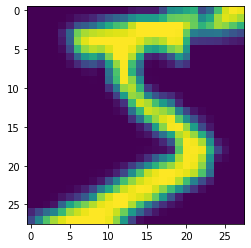

In [142]:
from cv2 import bitwise_not


def cb(img):
    img = bitwise_not(img)
    kernel = np.ones((2,2), np.uint8)
    img = cv.erode(img, kernel, iterations=1)
    mean = img.mean()
    non_empty_columns = np.where(img.min(axis=0)<mean)[0]
    non_empty_rows = np.where(img.min(axis=1)<mean)[0]
    boundingBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    bb = boundingBox
    img = img[bb[0]:bb[1], bb[2]:bb[3]]
    img = cv.bitwise_not(img)
    img = cv.resize(img, (28,28))
    return img

X_train = [cb(x) for x in X_train]
X_test = [cb(x) for x in X_test]

plt.imshow(X_train[0])

In [148]:
X_train = np.array(X_train)
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

train_datagen = ImageDataGenerator()

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train)
test_generator = valid_datagen.flow(X_test, y_test)

In [149]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1),
                 padding='same')),
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')),

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [150]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                      

In [151]:
#save model after evry epoch
checkpoint=tf.keras.callbacks.ModelCheckpoint("models/model-{epoch:02d}-{val_accuracy:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator, steps_per_epoch=60000//128, epochs=10, callbacks=callbacks_list)

Epoch 1/10
468/468 [==============================] - 13s 27ms/step - loss: 0.6628 - accuracy: 0.9173 - val_loss: 0.1163 - val_accuracy: 0.9643
Epoch 2/10
468/468 [==============================] - 13s 27ms/step - loss: 0.1016 - accuracy: 0.9693 - val_loss: 0.0824 - val_accuracy: 0.9749
Epoch 3/10
468/468 [==============================] - 13s 27ms/step - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.0681 - val_accuracy: 0.9806
Epoch 4/10
468/468 [==============================] - 13s 27ms/step - loss: 0.0661 - accuracy: 0.9789 - val_loss: 0.0733 - val_accuracy: 0.9777
Epoch 5/10
468/468 [==============================] - 13s 27ms/step - loss: 0.0530 - accuracy: 0.9836 - val_loss: 0.0702 - val_accuracy: 0.9777
Epoch 6/10
468/468 [==============================] - 13s 27ms/step - loss: 0.0522 - accuracy: 0.9840 - val_loss: 0.0444 - val_accuracy: 0.9863
Epoch 7/10
468/468 [==============================] - 13s 27ms/step - loss: 0.0442 - accuracy: 0.9868 - val_loss: 0.0464 - val_accuracy:

Text(0.5, 0, 'epochs')

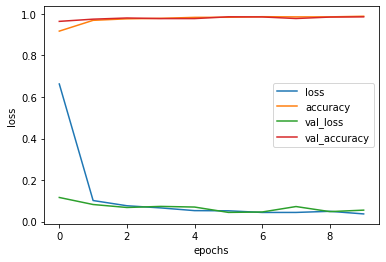

In [152]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [309]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0285 - accuracy: 0.9917


[0.028516730293631554, 0.9916999936103821]

In [153]:
model.save("model.h5")

In [27]:
from scipy import ndimage as ndi

def center_of_mass(img):
    cy, cx, _ = ndi.center_of_mass(img)
    img = img[int(cy)-20:int(cy)+20, int(cx)-20:int(cx)+20  ]
    return img


def prepare_box_test(img):
    img = np.array(img)
    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0, 5), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    # Left
    while img[:, 0].mean() <= 230:
        img = np.delete(img, 0, 1)

    # Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    mean = img.mean()

    if mean > 250:
        return cv.resize(img, (28, 28))

    cnts3 = img.copy()
    contours2, hierarchy2 = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    all_areas = []

    contours2 = sorted(contours2, key=cv.contourArea, reverse=True)
    contours2 = contours2[1:]

    for cnt in contours2:
        area = cv.contourArea(cnt)
        all_areas.append(area)

    if len(all_areas) == 0:
        return np.zeros((28, 28))

    avg_cnt = sum(all_areas) / len(all_areas)

    for cnt in contours2:
        area = cv.contourArea(cnt)
        if area < avg_cnt:
            cv.drawContours(cnts3, [cnt], -1, (255, 255, 255), -1)

    cnts3 = cnts3[5:]
    cnts3 = cnts3[:-5]
    cnts3 = np.delete(cnts3, range(0, 5), 1)
    cnts3 = np.delete(cnts3, range(-5, 0), 1)
    img = cnts3

    img = center_of_mass(img)
    #img = cv.bitwise_not(img)
    #img = cv.resize(img, (28, 28))

    return img

In [56]:
def cb(img):
    img = np.array(img)
    mean = img.mean()
    non_empty_columns = np.where(img.min(axis=0)<mean)[0]
    non_empty_rows = np.where(img.min(axis=1)<mean)[0]
    box_w = max(non_empty_rows)+5 - min(non_empty_rows)-5
    box_h = max(non_empty_columns) - min(non_empty_rows)
    center = (min(non_empty_rows)+int(box_w/2), min(non_empty_columns)+int(box_h/2))   
    bb = (center[0]-20, center[0]+20, center[1]-20, center[1]+20)
    return bb

def prepeare_img(img):
    img = np.array(img)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    #Left
    while img[:,0].mean() <= 230:
        img = np.delete(img, 0, 1)

    #Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0,10), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    #Left
    while img[:,0].mean() <= 230:
        img = np.delete(img, 0, 1)

    #Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    
    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0,5), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    #Left
    while img[:,0].mean() <= 230:
        img = np.delete(img, 0, 1)

    #Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)


    cnts3 = img.copy()
    contours2, hierarchy2 = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    all_areas= []

    contours2 = sorted(contours2, key=cv.contourArea, reverse=True)
    contours2 = contours2[1:]

    for cnt in contours2:
        area= cv.contourArea(cnt)
        all_areas.append(area)
    
    avg_cnt = sum(all_areas)/len(all_areas)

    for cnt in contours2:
        area = cv.contourArea(cnt)
        if area < avg_cnt:
            cv.drawContours(cnts3, [cnt], -1, (255,255,255), -1)

    cnts3 = cnts3[5:]
    cnts3 = cnts3[:-5]
    cnts3 = np.delete(cnts3, range(0,5), 1)
    cnts3 = np.delete(cnts3, range(-5, 0), 1)

    return cnts3


def pred_and_plot(img_path, model_path):
    model = tf.keras.models.load_model(model_path)
    fig = plt.figure(figsize=(10, 7))
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1)

    fig.add_subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis(False)

    img2 = img
    img1 = prepeare_img(img)
    img2 = img1
    bb = cb(img1)

    fig.add_subplot(1, 4, 2)
    plt.imshow(img1)
    plt.plot([bb[2], bb[3], bb[3], bb[2], bb[2]],
            [bb[0], bb[0],bb[1], bb[1], bb[0]],
            "r-")
    plt.axis(False)

    img1 = img1[bb[0]:bb[1], bb[2]:bb[3]] 
    img1 = cv.bitwise_not(img1)
    img1 = cv.resize(img1, (28,28))

    img2 = prepare_box_test(img2)
    img2 = cv.bitwise_not(img2)
    img2 = cv.resize(img2, (28,28))
    
    fig.add_subplot(1, 4, 3)
    plt.imshow(img1)
    plt.axis(False)
    img1 = tf.expand_dims(img1, 0)
    plt.title(np.argmax(model.predict(img1)))

    fig.add_subplot(1, 4, 4)
    plt.imshow(img2)
    plt.axis(False)
    img2 = tf.expand_dims(img2, 0)
    plt.title(np.argmax(model.predict(img2)))

    plt.axis(False)
    plt.colorbar;




(43, 36)


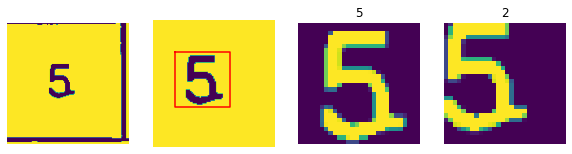

In [74]:
pred_and_plot("box_pre74.png", "models/model-08-0.99.h5")